# LSTM_model

This notebook contains the functions for the words embeddings (using [GloVe](https://nlp.stanford.edu/projects/glove/)) as well as the training of the model to classify the genre of a movie based on its overview.

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import time

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('datasets/preprocessed.csv')
df.dropna(inplace = True)

In [4]:
df.head()

,original_title,overview,genres,genre label
0,Toy Story,led woody andy toys live happily room andy bir...,Animation,2
1,Jumanji,siblings judy peter discover enchanted board g...,Adventure,1
2,Grumpier Old Men,family wedding reignites ancient feud neighbor...,Romance,17
3,Waiting to Exhale,cheated mistreated stepped women holding breat...,Comedy,5
4,Father of the Bride Part II,george banks recovered daughter wedding receiv...,Comedy,5


## Check the amount of datapoints per genre

In this section, we check that the amount of datapoints for each class is equal

In [14]:
import nltk
from nltk import FreqDist

genreCol = df['genres'].tolist()
fdist1 = FreqDist(genreCol)

In [15]:
fdist1.most_common(50)

[('Drama', 11803),
 ('Comedy', 8515),
 ('Action', 4465),
 ('Documentary', 3376),
 ('Horror', 2612),
 ('Crime', 1662),
 ('Thriller', 1646),
 ('Adventure', 1502),
 ('Romance', 1163),
 ('Animation', 1114),
 ('Fantasy', 696),
 ('Science Fiction', 639),
 ('Mystery', 547),
 ('Family', 508),
 ('Music', 480),
 ('Western', 449),
 ('TV Movie', 381),
 ('War', 373),
 ('History', 273),
 ('Foreign', 116),
 ('Carousel Productions', 1),
 ('Aniplex', 1),
 ('Odyssey Media', 1)]

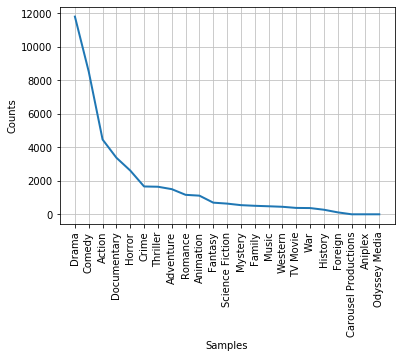

In [16]:
fdist1.plot(50, cumulative=False)

In [20]:
over300 = sorted(w for w in set(genreCol) if fdist1[w] > 300)
print(over300)
print(len(over300))

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
18


## Sample the dataset such that the

## Obtain the 100-dimensional GloVe embeddings 

In the case of this project, we are only interested in the words that contain only letters in the alphabet.

In [6]:
def read_glove_vecs_only_alpha(glove_file):
    
    with open(glove_file, 'r',encoding='utf8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            
            # only consider words containing alphabetical letters
            if curr_word.isalpha():
                words.add(curr_word)
                word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
            
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
# obtain the GloVe dataset of dimensionality 100
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs_only_alpha('datasets/glove.6B/glove.6B.100d.txt')

In [ ]:
# sanity check to ensure that they are all of same length
print(len(word_to_index), len(index_to_word), len(word_to_vec_map))

## Determine the maximum sequence length

In [ ]:
df['overview length'] = df['overview'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(df["overview length"].mean()))
print("max length of sentence: " + str(df["overview length"].max()))
print("std dev length of sentence: " + str(df["overview length"].std()))

In [ ]:
# determine the maximum length of a movie overview
max_sequence_length = df["overview length"].max()

## Convert the sentences to their respective indices and define the embedding layer

In [ ]:
df.head(5)

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can betest = pd.read_csv('datasets/genreLabels.csv') given to `Embedding()` 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    # number of training examples
    m = X.shape[0]                                   
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    # loop over training examples
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words -> get a list of words.
        sentence_words = [x.lower() for x in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words in sentence_words
        for w in sentence_words:
            
            # check that the word is within our GloVe dataset, otherwise pass
            if w in word_to_index.keys():
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                
                # Increment j to j + 1
                j = j+1
            else:
                pass
                
    return X_indices

In [ ]:
# test the function
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = max_sequence_length)
print("X1 =", X1)
print("X1_indices =", X1_indices)

In [ ]:
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 100-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1    
    
    # define dimensionality of your GloVe word vectors (in our case 100)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False) 

    # Build the embedding layer, required before setting the weights of the embedding layer
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

In [ ]:
def GenreClassifier(input_shape, word_to_vec_map, word_to_index, nbClasses):
    """
    Function creating the graph of the model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras 
    """
    
    # Define input of the graph of dtype 'int32' as it contains indices
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors 
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # output is a batch of sequences
    X = LSTM(128, return_sequences = True)(embeddings)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences = False, return_state = False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 23-dimensional vectors.
    X = Dense(nbClasses)(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
        
    return model

In [ ]:
X = df['overview'].values
y = df['genre label'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print("There are " +str(len(X_train)) + " samples in the training set")
print("There are " +str(len(X_test)) + " samples in the test set")

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_sequence_length)
y_train_oh = convert_to_one_hot(y_train, C = len(df["genres"].unique()))

In [ ]:
#credits of function to http://parneetk.github.io/blog/neural-networks-in-keras/
def plot_model_history(model_history):
    
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('graphs/history_early_stopping_21_11_not_preprocessed.png')
    plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
import time

def trainModel(X_train_indices, Y_train_oh, word_to_vec_map, word_to_index, max_length, summary = False, 
               dropout_rate = 0.5, batch_size = 32, epochs = 50, loss ='categorical_crossentropy', 
               optimizer ='adam'):
    
    model = GenreClassifier((max_sequence_length,), word_to_vec_map, word_to_index, len(df["genres"].unique()))
    
    if summary:
        model.summary()
        
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1, mode='auto')
    callbacks_list = [earlystop]
    
    start = time.time()
    history = model.fit(X_train_indices, Y_train_oh, epochs = 50, 
                             callbacks=None, batch_size = batch_size, validation_split = 0.1, shuffle=True)
    end = time.time()
    print("Model took {} seconds (which is {} minutes or {} hours) to train".format((end - start), (end - start)/60, (end - start)/3600))
    
    return history, model

In [ ]:
history, model = trainModel(X_train_indices, y_train_oh, word_to_vec_map, word_to_index, max_length = max_sequence_length)

W0705 18:07:38.372873 140002886326016 deprecation.py:506] From /home/thoo2/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0705 18:07:38.573178 140002886326016 deprecation_wrapper.py:119] From /home/thoo2/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 18:07:38.829218 140002886326016 deprecation.py:323] From /home/thoo2/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updati

Train on 25520 samples, validate on 2836 samples
Epoch 1/50
25520/25520 [==============================] - 446s 17ms/step - loss: 2.3855 - acc: 0.2647 - val_loss: 2.3106 - val_acc: 0.2948
Epoch 2/50
25520/25520 [==============================] - 445s 17ms/step - loss: 2.3558 - acc: 0.2732 - val_loss: 2.3099 - val_acc: 0.2948
Epoch 3/50
25520/25520 [==============================] - 446s 17ms/step - loss: 2.3498 - acc: 0.2772 - val_loss: 2.3099 - val_acc: 0.2948
Epoch 4/50
25520/25520 [==============================] - 461s 18ms/step - loss: 2.3464 - acc: 0.2774 - val_loss: 2.3122 - val_acc: 0.2948
Epoch 5/50
25520/25520 [==============================] - 498s 20ms/step - loss: 2.3433 - acc: 0.2772 - val_loss: 2.3105 - val_acc: 0.2948
Epoch 6/50
25520/25520 [==============================] - 552s 22ms/step - loss: 2.3414 - acc: 0.2773 - val_loss: 2.3114 - val_acc: 0.2948
Epoch 7/50
 8064/25520 [========>.....................] - ETA: 30:54 - loss: 2.3536 - acc: 0.2765

In [ ]:
model.save_weights("models/Epochs50_Adam_CCloss.h5") 

In [ ]:
plot_model_history(history)

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = max_sequence_length)
y_test_oh = convert_to_one_hot(y_test, C = len(df["genres"].unique()))
loss, acc = model.evaluate(X_test_indices, y_test_oh)

print("Test accuracy = ", acc)